# Conditional Image Synthesis With Auxiliary Classifier GANs
https://arxiv.org/abs/1610.09585

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar

from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Загружаем исходные данные

In [0]:
train = np.loadtxt('/content/drive/My Drive/Colab Data/digit/train.csv', delimiter=',', skiprows=1)

In [0]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обработки виду
train_img = np.expand_dims(np.reshape(train[:, 1:], (len(train[:, 1:]), 28, 28)), axis=-1)

In [0]:
# Нормируем исходные данные
train_img = (train_img.astype(np.float32) - 127.5) / 127.5

In [0]:
from sklearn.model_selection import train_test_split
(y_train, y_test,
 x_train, x_test) = train_test_split(train_label, train_img,
                            test_size=0.2, random_state=42)

## Визуализируем данные

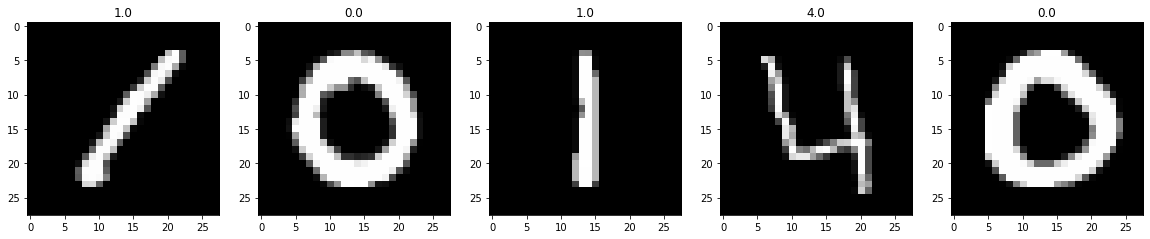

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[...,0], cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Задаем архитектуру генератора и дискриминатора

In [0]:
def build_generator(latent_size, num_classes=10):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 28, 28, 1)
    
    # this is the z space commonly referred to in GAN papers
    latent = Input(shape=(latent_size, ))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')   

    cls = Embedding(num_classes, latent_size,
                    embeddings_initializer='glorot_normal')(image_class)

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])
    
    x = Dense(3 * 3 * 384, activation='relu')(h)
    x = Reshape((3, 3, 384))(x)

    # upsample to (7, 7, ...)
    x = Conv2DTranspose(192, 5, strides=1, padding='valid',
                        activation='relu',
                        kernel_initializer='glorot_normal')(x)
    
    x = BatchNormalization(axis=-1)(x)

    # upsample to (14, 14, ...)
    x = Conv2DTranspose(96, 5, strides=2, padding='same',
                            activation='relu',
                            kernel_initializer='glorot_normal')(x)
    x = BatchNormalization()(x)

    # upsample to (28, 28, ...)
    fake_image = Conv2DTranspose(1, 5, strides=2, padding='same',
                                 activation='tanh',
                                 kernel_initializer='glorot_normal')(x)

    return Model([latent, image_class], fake_image)


def build_discriminator(num_classes):
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Conv2D(32, 3, padding='same', strides=2,
                   input_shape=(28, 28, 1)))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(rate=0.7))

    cnn.add(Conv2D(64, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(128, 3, padding='same', strides=2))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(rate=0.7))

    cnn.add(Conv2D(256, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(rate=0.7))

    cnn.add(Flatten())

    image = Input(shape=(28, 28, 1))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(num_classes, activation='softmax', name='auxiliary')(features)

    return Model(image, [fake, aux])

## Объединяем дискриминатор и генератор в общую модель

In [10]:
NUM_CLASSES = 10
LATENT_SIZE = 100

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5

# build the discriminator
print('Discriminator model:')
discriminator = build_discriminator(NUM_CLASSES)
discriminator.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy',
          'sparse_categorical_crossentropy']
)
discriminator.summary()

# build the generator
generator = build_generator(LATENT_SIZE)

latent = Input(shape=(LATENT_SIZE, ))
image_class = Input(shape=(1,), dtype='int32')

# get a fake image
fake = generator([latent, image_class])

discriminator_freezed = Model(discriminator.inputs, discriminator.outputs)
discriminator_freezed.trainable = False

# we only want to be able to train generation for the combined model
fake, aux = discriminator_freezed(fake)
combined = Model([latent, image_class], [fake, aux])

print('Combined model:')
combined.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)
combined.summary()

Discriminator model:
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 12544)        387840      input_1[0][0]                    
__________________________________________________________________________________________________
generation (Dense)              (None, 1)            12545       sequential[1][0]                 
________________________________________________________________________________________________

## Запускаем обучение

In [0]:
from collections import defaultdict

# batch and latent size taken from the paper
epochs = 10
batch_size = 100

num_train, num_test = x_train.shape[0], x_test.shape[0]

train_history = defaultdict(list)
test_history = defaultdict(list)

for epoch in range(1, epochs + 1):
    print('Epoch {}/{}'.format(epoch, epochs))

    num_batches = int(np.ceil(x_train.shape[0] / float(batch_size)))
    progress_bar = Progbar(target=num_batches)

    epoch_gen_loss = []
    epoch_disc_loss = []

    for index in range(num_batches):
        # get a batch of real images
        image_batch = x_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]

        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (len(image_batch), LATENT_SIZE))

        # sample some labels from p_c
        sampled_labels = np.random.randint(0, NUM_CLASSES, len(image_batch))

        # generate a batch of fake images, using the generated labels as a
        # conditioner. We reshape the sampled labels to be
        # (len(image_batch), 1) so that we can feed them into the embedding
        # layer as a length one sequence
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=0)

        x = np.concatenate((image_batch, generated_images))

        # use one-sided soft real/fake labels
        # Salimans et al., 2016
        # https://arxiv.org/pdf/1606.03498.pdf (Section 3.4)
        soft_zero, soft_one = 0, 0.95
        y = np.array(
            [soft_one] * len(image_batch) + [soft_zero] * len(image_batch))
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

        # we don't want the discriminator to also maximize the classification
        # accuracy of the auxiliary classifier on generated images, so we
        # don't train discriminator to produce class labels for generated
        # images (see https://openreview.net/forum?id=rJXTf9Bxg).
        # To preserve sum of sample weights for the auxiliary classifier,
        # we assign sample weight of 2 to the real images.
        disc_sample_weight = [np.ones(2 * len(image_batch)),
                              np.concatenate((np.ones(len(image_batch)) * 2,
                                              np.zeros(len(image_batch))))]

        # see if the discriminator can figure itself out...
        epoch_disc_loss.append(discriminator.train_on_batch(
            x, [y, aux_y], sample_weight=disc_sample_weight))

        # make new noise. we generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator
        noise = np.random.uniform(-1, 1, (2 * len(image_batch), LATENT_SIZE))
        sampled_labels = np.random.randint(0, NUM_CLASSES, 2 * len(image_batch))

        # we want to train the generator to trick the discriminator
        # For the generator, we want all the {fake, not-fake} labels to say
        # not-fake
        trick = np.ones(2 * len(image_batch)) * soft_one

        epoch_gen_loss.append(combined.train_on_batch(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels]))

        progress_bar.update(index + 1)

    print('Testing for epoch {}:'.format(epoch))

    # evaluate the testing loss here

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (num_test, LATENT_SIZE))

    # sample some labels from p_c and generate images from them
    sampled_labels = np.random.randint(0, NUM_CLASSES, num_test)
    generated_images = generator.predict(
        [noise, sampled_labels.reshape((-1, 1))], verbose=False)

    x = np.concatenate((x_test, generated_images))
    y = np.array([1] * num_test + [0] * num_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)

    # see if the discriminator can figure itself out...
    discriminator_test_loss = discriminator.evaluate(
        x, [y, aux_y], verbose=False)

    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

    # make new noise
    noise = np.random.uniform(-1, 1, (2 * num_test, LATENT_SIZE))
    sampled_labels = np.random.randint(0, NUM_CLASSES, 2 * num_test)

    trick = np.ones(2 * num_test)

    generator_test_loss = combined.evaluate(
        [noise, sampled_labels.reshape((-1, 1))],
        [trick, sampled_labels], verbose=False)

    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    # generate an epoch report on performance
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *discriminator.metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.4f} | {3:<5.4f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                         *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                         *test_history['discriminator'][-1]))

    # save weights every epoch
    generator.save_weights(
        'mnist_generator_{0:03d}.hd5'.format(epoch), save_format='h5')
    discriminator.save_weights(
        'mnist_discriminator_{0:03d}.hd5'.format(epoch), save_format='h5')

## Загружаем предобученный генератор

In [0]:
generator.load_weights('/content/drive/My Drive/Colab Data/digit/mnist_generator_010.hd5')

## Генерируем изображения и сравниваем с реальными данными

In [0]:
# generate some digits to display
num_rows = 40
noise = np.tile(np.random.uniform(-1, 1, (num_rows, LATENT_SIZE)),
                (NUM_CLASSES, 1))

sampled_labels = np.array([
    [i] * num_rows for i in range(NUM_CLASSES)
]).reshape(-1, 1)

# get a batch to display
generated_images = generator.predict(
    [noise, sampled_labels], verbose=0)

# prepare real images sorted by class label
real_labels = y_test[:num_rows * NUM_CLASSES]

indices = np.argsort(real_labels, axis=0)
real_images = x_test[:num_rows * NUM_CLASSES][indices]

# display generated images, white separator, real images
img = np.concatenate(
    (generated_images,
     np.repeat(np.ones_like(x_train[:1]), num_rows, axis=0),
     real_images))

# arrange them into a grid
img = (np.concatenate([r.reshape(-1, 28)
                       for r in np.split(img, 2 * NUM_CLASSES + 1)
                       ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

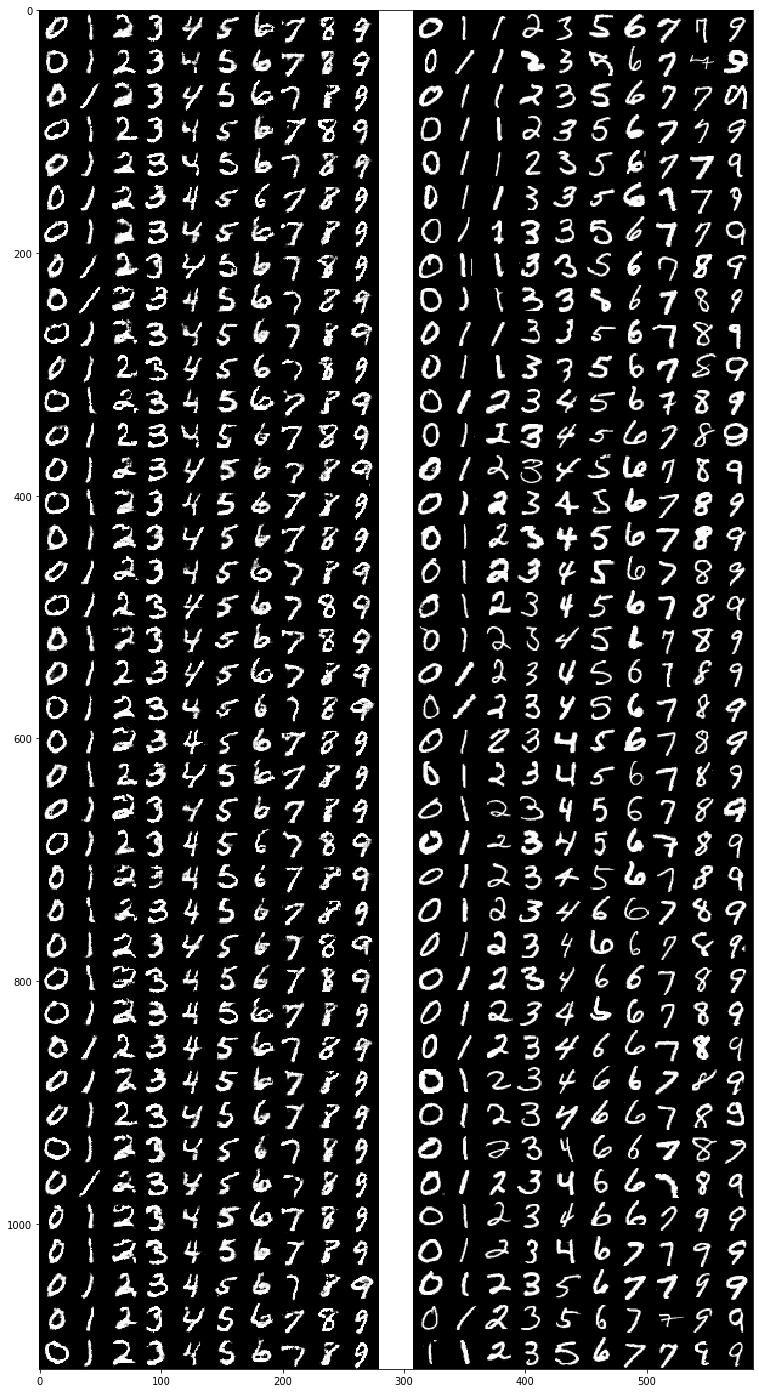

In [15]:
plt.figure(figsize=(15, 25))
plt.imshow(img, cmap='gray')

In [0]:
pass